## Notebook setup

In [91]:
import sys

sys.path.append('../src')

import pandas as pd
import os
from db.connection import ConexionBD
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

%matplotlib inline

In [92]:
conn = ConexionBD.obtener_conexion()

## Expenses anylisis

**Data setup**

In [93]:
query = """
    SELECT fecha_valor, importe, saldo
    FROM bancapp.movimientos_mview
    """

results =  conn.execute(query).fetchall()
df = pd.DataFrame(results)
                 
# Convierte múltiples columnas a numérico; si encuentra basura, pone NaN
cols_numericas = ['importe', 'saldo']
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce')

# Convierte a fecha
df['fecha_valor'] = pd.to_datetime(df['fecha_valor'])
df['mes_valor'] = df["fecha_valor"].dt.month
df['anio_valor'] = df["fecha_valor"].dt.year

**Expenses dataframe**

In [94]:
df_gastos = df[df.importe<0][["fecha_valor","mes_valor","anio_valor", "importe"]]
df_gastos["importe"] = df_gastos["importe"].apply(abs)

In [95]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2010 entries, 0 to 2323
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha_valor  2010 non-null   datetime64[ns]
 1   mes_valor    2010 non-null   int32         
 2   anio_valor   2010 non-null   int32         
 3   importe      2010 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 62.8 KB


In [96]:
df_gastos.importe.describe([.25, .5, .75, .90, .95, .99])

count    2010.000000
mean       74.148184
std       242.325766
min         0.490000
25%        10.402500
50%        27.240000
75%        72.127500
90%       200.000000
95%       301.000000
99%       495.670000
max      9000.000000
Name: importe, dtype: float64

**Outliers**

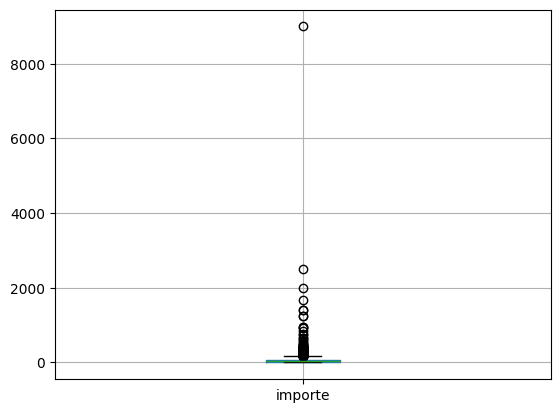

In [97]:
df_gastos.boxplot(column="importe");

In [98]:
IQR = df_gastos.importe.quantile(0.75) - df_gastos.importe.quantile(0.25)

higher_fence = df_gastos.importe.quantile(0.75) + (IQR * 1.5)

print("Valor límite de gastos para atípicos: ", higher_fence)

Valor límite de gastos para atípicos:  164.71499999999997


Remove outliers

In [99]:
df_gastos_nooutliers = df_gastos[df_gastos.importe < higher_fence]

In [100]:
df_gastos_nooutliers.importe.describe([.25, .5, .75, .90, .95, .99])

count    1767.000000
mean       34.122037
std        33.355227
min         0.490000
25%         9.655000
50%        22.000000
75%        49.900000
90%        80.850000
95%       102.900000
99%       145.966800
max       163.000000
Name: importe, dtype: float64

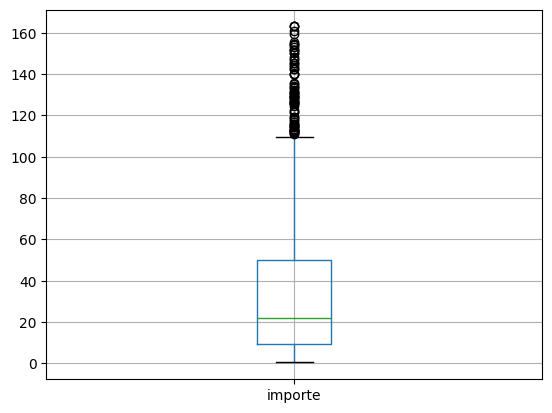

In [101]:
df_gastos_nooutliers.boxplot(column="importe");

**Expenses by year (with trend)**

In [102]:
df_gastos_nooutliers_by_month = df_gastos_nooutliers.groupby(by=["anio_valor","mes_valor"]).agg(gasto_total=("importe","sum"))

Tendencia

In [103]:
from sklearn import linear_model

reg = linear_model.LinearRegression()

X = np.arange(0,len(df_gastos_nooutliers_by_month["gasto_total"])).reshape(-1, 1)
y = df_gastos_nooutliers_by_month["gasto_total"].values

tendencia = reg.fit(X,y).predict(X)


Plot

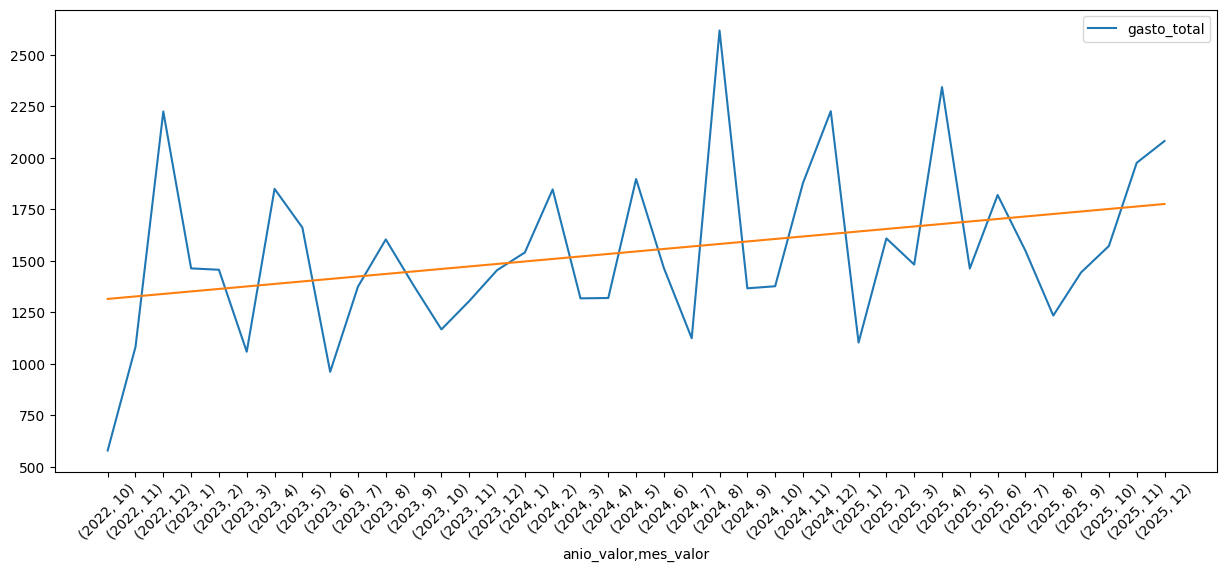

In [104]:
df_gastos_nooutliers_by_month.plot.line(rot=45, figsize=(15,6));
plt.plot(X, tendencia)
plt.xticks(range(len(df_gastos_nooutliers_by_month.gasto_total)),df_gastos_nooutliers_by_month.index, rotation=45)
plt.show();

In [105]:
minimo = float(min(tendencia))
maximo = float(max(tendencia))
print(f"Tendencia - min:{minimo:.0f} max:{maximo:.0f}")

Tendencia - min:1316 max:1776


In [106]:
aumento = (maximo-minimo) / minimo
print(aumento)

0.3502922271028742


**Outliers analysis**

In [107]:
df_gastos_outliers = df_gastos[df_gastos.importe >= higher_fence]

In [108]:
df_gastos_outliers.importe.describe([.25, .5, .75, .90, .95, .99])

count     243.000000
mean      365.202510
std       618.553315
min       165.120000
25%       203.460000
50%       263.000000
75%       337.000000
90%       436.200000
95%       770.703000
99%      1868.019200
max      9000.000000
Name: importe, dtype: float64

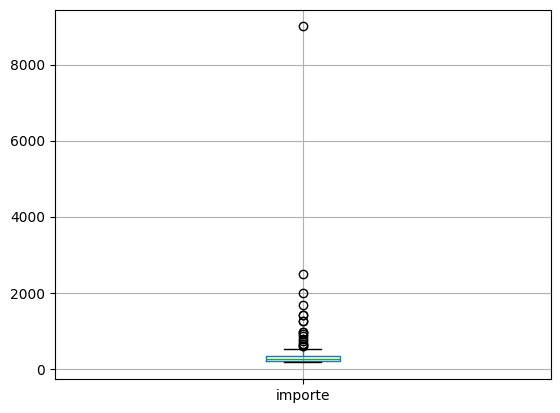

In [109]:
df_gastos_outliers.boxplot(column="importe");

Remove outliers from the outliers

In [110]:
IQR = df_gastos_outliers.importe.quantile(0.75) - df_gastos_outliers.importe.quantile(0.25)

higher_fence = df_gastos_outliers.importe.quantile(0.75) + (IQR * 1.5)

print("Valor límite de gastos para atípicos: ", higher_fence)

Valor límite de gastos para atípicos:  537.31


In [111]:
df_gastos_outliers_2 = df_gastos[df_gastos.importe < higher_fence]

In [112]:
df_gastos_outliers_by_month = df_gastos_outliers_2.groupby(by=["anio_valor","mes_valor"]).agg(gasto_total=("importe","sum"))

In [113]:
from sklearn import linear_model

reg = linear_model.LinearRegression()

X = np.arange(0,len(df_gastos_outliers_by_month["gasto_total"])).reshape(-1, 1)
y = df_gastos_outliers_by_month["gasto_total"].values

tendencia = reg.fit(X,y).predict(X)


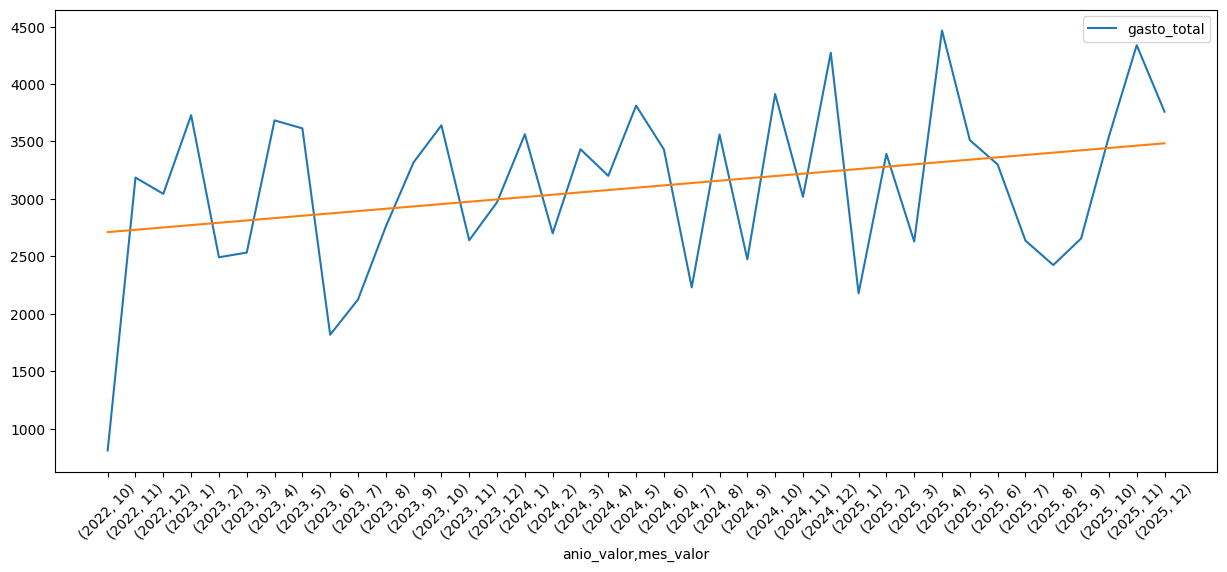

In [114]:
df_gastos_outliers_by_month.plot.line(rot=45, figsize=(15,6));
plt.plot(X, tendencia)
plt.xticks(range(len(df_gastos_outliers_by_month.gasto_total)),df_gastos_outliers_by_month.index, rotation=45)
plt.show();

In [115]:
minimo = float(min(tendencia))
maximo = float(max(tendencia))
print(f"Tendencia - min:{minimo:.0f} max:{maximo:.0f}")

Tendencia - min:2711 max:3484


In [116]:
aumento = (maximo-minimo) / minimo
print(aumento)

0.28518787962892295
